<a href="https://colab.research.google.com/github/FukuokaIruka/Ex3/blob/main/jikken3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験３：ニューラル機械翻訳（Neural Machine Translations）



文章の翻訳を行うための典型的なアプローチの1つが、**エンコーダ・デコーダモデル（Encoder–Decoder Architecture）**です。

* エンコーダ：入力文をベクトルに圧縮（文の意味を抽出）
* デコーダ：そのベクトルから翻訳先の文を順に生成

例：

入力：I am a student.

出力：私は 学生 です。

この構造は、先に学んだ RNNやLSTM をベースに作られています。



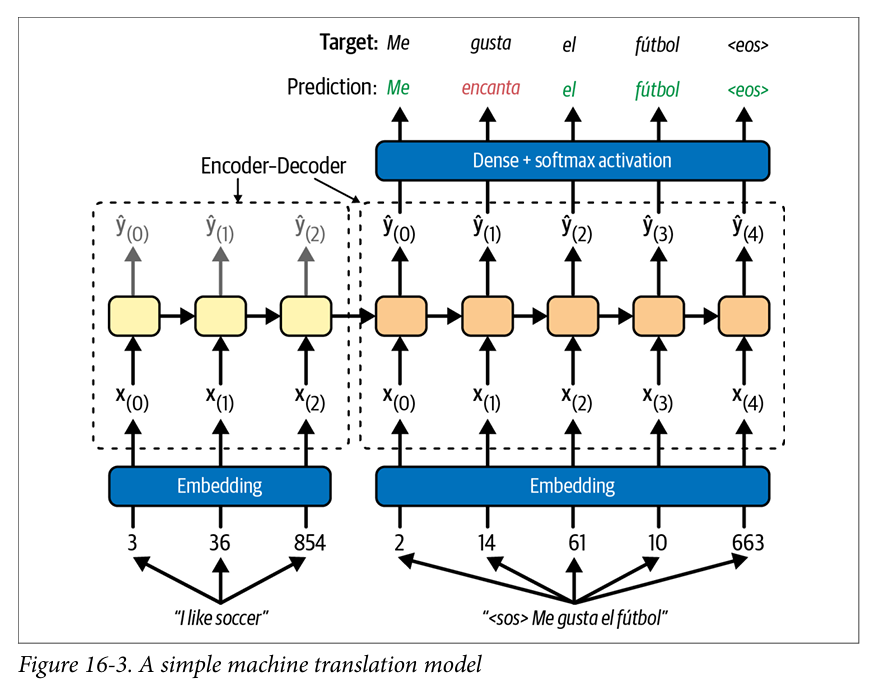

この図は、「I like soccer」→「Me gusta el fútbol」 という英語からスペイン語への翻訳を行う、シンプルなエンコーダ・デコーダモデルを示しています。

## エンコーダ・デコーダ構造

### エンコーダ（左側）

* 英語の入力文 `"I like soccer"` を1単語ずつ受け取ります。
* 各単語はあらかじめ辞書で定義された **ID（例：3, 36, 854）** に変換されます。
* このIDは **Embedding層** を通して、多次元の連続ベクトルに変換されます。
  → このベクトルが「単語の潜在空間にある位置（意味）」となります。
* 最後の単語まで順番に処理されると、**文全体の意味を表す状態**がデコーダに渡されます。

### デコーダ（右側）

* デコーダの入力は、まず **```<sos>```（Start of Sequence）トークン** から始まります。
* その後、出力文を1単語ずつ予測します。

### Teacher Forcing

訓練時には、モデルの予測結果を次の入力に使うのではなく、**正解の単語（ターゲット文）を次の入力に使う**という手法をとります。

* 例：`Me` を予測した後、モデルが間違えて `encanta` と出力しても、
* 次のステップの入力には **正解の `gusta`** を与える

これにより、モデルは学習初期でも**正しい文脈で学習しやすく**なります。

### 特別なトークン：```<sos>``` と ```<eos>```

* `<sos>`（Start of Sequence）：文の生成を開始するための印
* `<eos>`（End of Sequence）：生成の終了を示すマーカー

モデルは `<eos>` を出力した時点で文の出力を止めます。


### 単語のIDとEmbedding

* すべての単語は、あらかじめ語彙リスト（辞書）で **整数のID** に変換されます
* そのIDを **Embedding層** を通して、多次元ベクトル（意味表現）に変換
* Embeddingはエンコーダ・デコーダ両方に使われます（通常は共有されない）

### 最終出力

各ステップの出力は、Dense層（全結合）＋Softmax関数で語彙リストの中から**次の単語を予測**します。

> 予測された単語が「Me → gusta → el → fútbol → <eos>」のようになれば正解！

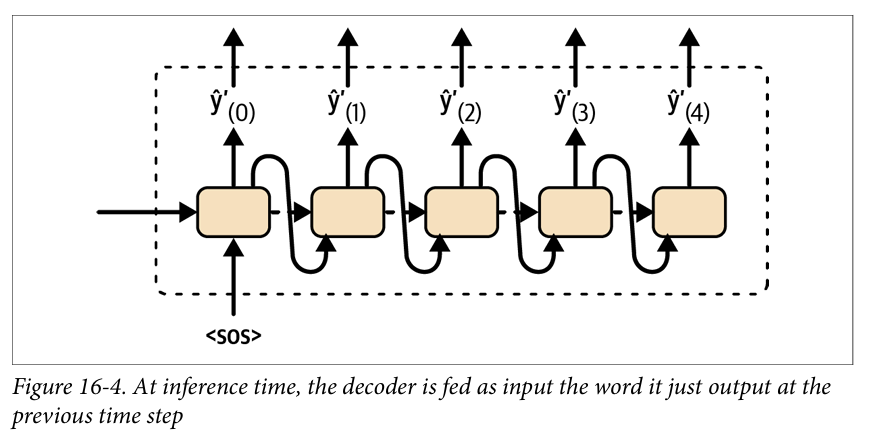

## エンコーダ・デコーダの実装

Imports

In [1]:
import sys

IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

英語・スペイン語の「文ペア」データセット

In [3]:
from pathlib import Path

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

2638744/2638744 [==============================] - 1s 0us/step


¡ と ¿ を削除して、シャフルします。
そして、二つのリスト（英語とスペイン語）にする。

In [4]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

最初の３つの文ペア：

In [5]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


### テキストベクトル化と前処理

以下のコードは、英語とスペイン語の文を **数値ベクトル（整数列）** に変換するための前処理です。
ニューラルネットワークではテキストを直接扱えないため、まず**単語を数値IDに変換する**必要があります。

`TextVectorization` は、以下のような変換を自動で行ってくれるレイヤーです：

* 文 → 単語ごとのトークンに分割（tokenization）
* トークン → 語彙IDに変換（word → integer）
* 必要に応じてパディングや切り捨て（長さの調整）

このレイヤーは、**事前に与えた文から語彙リストを学習（adapt）**します。

`vocab_size = 1000`

* 学習データがそれほど大きくないため、**語彙サイズ（扱う単語の数）を1000に制限**
* 頻度の高い上位1000語のみを対象とすることで、**計算コストと過学習のリスクを減らす**

`output_sequence_length = 50`

* 出力される文の長さを最大50語に統一
* 50未満の文には **自動的に '0'（パディング）** が追加される

スペイン語の方（デコーダ）には **「どこから文が始まり、どこで終わるか」** の情報が必要
* そのため、各文の前に`<sos>`、後ろに `<eos>`を追加
* モデルは `<sos>` を見て文の生成を開始し、 `<eos>` が出力されたら生成を終了

In [6]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

語彙の辞書 unknown is also included

In [7]:
text_vec_layer_en.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom'),
 np.str_('a'),
 np.str_('is'),
 np.str_('he')]

In [8]:
text_vec_layer_es.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('startofseq'),
 np.str_('endofseq'),
 np.str_('de'),
 np.str_('que'),
 np.str_('a'),
 np.str_('no'),
 np.str_('tom'),
 np.str_('la')]

データセットの分割

* デコーダの入力は必ず`<sos>`から始まって
* デコーダの正解は必ず`<eos>`まで終わる

In [9]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [10]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [11]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [12]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [13]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [14]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 90s 25ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
3125/3125 [==============================] - 67s 21ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
2608/3125 [========================>.....] - ETA: 8s - loss: nan - accuracy: 0.0000e+00

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
translate("I like soccer")

1/1 [==============================] - 0s 20ms/step


'me gusta el fútbol'

In [ ]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 20ms/step


'me gusta mucho la cocina y [UNK] la semana pasada'

## 双方向RNN（Bidirectional RNN）

通常のRNNは、**過去 → 現在へと一方向**にしか情報を伝えることができません。
しかし、言語の理解には「未来の文脈」も非常に重要です。
図は、双方向RNNの構造を表しています：

* **オレンジ色の矢印**：入力 $x_0, x_1, x_2$ を **左→右（順方向）** に処理するRNN
* **紫色の矢印**：入力を **右→左（逆方向）** に処理するRNN

各時刻ステップでは：

1. 順方向のRNNが「過去からの情報」を使って出力を計算
2. 逆方向のRNNが「未来からの情報」を使って出力を計算
3. それぞれの出力を **結合（concatenate）** して、最終的な出力 $\hat{y}_t$ を得る

### なぜ双方向にするのか？
例：文の一部だけを見て意味が曖昧なとき

>「the **right** arm」（右腕）

>「the **right** person」（ぴったり合う人）

>「the **right** to criticize」（批判する権利）

* 順方向だけでは「right」に来た時点では判断できない
* 逆方向もあれば見分けられる情報を活かせる

### 双方向RNNの特徴

* 入力系列全体を使って**文脈をより深く理解**できる
* 特に、**エンコーダ部分**に使うと翻訳や分類精度が向上する
* デコーダでは未来が見えないため通常は使わない（注意点）

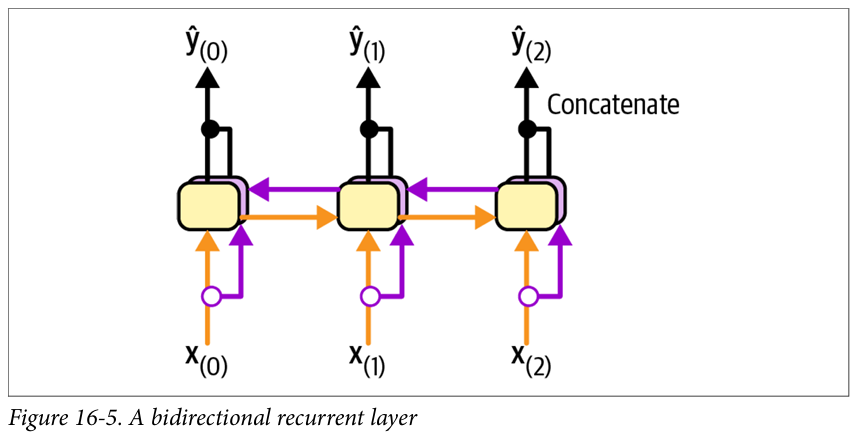

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 135s 37ms/step - loss: 2.1262 - accuracy: 0.5461 - val_loss: 1.4971 - val_accuracy: 0.6412
Epoch 2/10
3125/3125 [==============================] - 125s 40ms/step - loss: 1.3003 - accuracy: 0.6783 - val_loss: 1.2869 - val_accuracy: 0.6794
Epoch 3/10
3125/3125 [==============================] - 102s 33ms/step - loss: 1.0821 - accuracy: 0.7206 - val_loss: 1.2041 - val_accuracy: 0.6990
Epoch 4/10
3125/3125 [==============================] - 84s 27ms/step - loss: 0.9352 - accuracy: 0.7509 - val_loss: 1.1792 - val_accuracy: 0.7042
Epoch 5/10
3125/3125 [==============================] - 84s 27ms/step - loss: 0.8148 - accuracy: 0.7769 - val_loss: 1.1872 - val_accuracy: 0.7045
Epoch 6/10
3125/3125 [==============================] - 78s 25ms/step - loss: 0.7112 - accuracy: 0.8006 - val_loss: 1.2074 - val_accuracy: 0.7027
Epoch 7/10
3125/3125 [==============================] - 76s 24ms/step - loss: 0.6228 - accuracy: 0.8218 - val_loss: 1.239

In [ ]:
translate("I like soccer")

1/1 [==============================] - 0s 21ms/step


'me gusta el fútbol'

## Beam Search（ビーム探索）

生成モデル（例：翻訳モデル）では、**次に出力する単語**を1語ずつ予測していきます。
このとき、「最も確率が高い単語を毎回1つ選ぶ」だけでは、**文全体として不自然な出力**になることがあります。

例：I like soccer
* me gusta el fútbol の方が正しい
* モデルが me gustan los jugadores (I like the players) を出力した
* データによると、「I like cars」などの文が多い
  * 正解は「me gustan los autos」
  * モデルが誤って me gustan を出力すれば、次は el を出力する確率が非常に低くなった
  * もう me gustan los jugadores を出力しなければならなかった（一応サッカーとのつながりがある）

この図では、`Me` を最初に出力した後、**確率の高い上位3つの候補（beam width = 3）** を残しながら文を生成しています。

* 各ステップでの予測確率を **累積積（乗算）** していきます
  例：`Me` (75%) → `gusta` (32%) → `el` (33%)
  → 全体スコア：`0.75 × 0.32 × 0.33 ≈ 8%`

### Beam Searchの流れ（概要）

1. 最初のトークン（例：Me）を出力
2. 次に出力する候補を複数（上位3つなど）残す
3. 各候補についてさらに次の単語を予測し、スコアを更新
4. **スコアの高い順に再度上位3つを選び直す**
5. これを繰り返して、**最終的に一番良い系列（文）**を選ぶ


### Beam Searchのメリット

* 毎回1語だけを選ぶ「貪欲法（greedy search）」に比べて、**文全体の最適性**が高い
* **より自然な文**が得られやすい
* **複数候補を残す**ため、柔軟な生成が可能

### 注意点

* ビーム幅が大きいほど、計算量は増えるが精度も高くなる傾向
* あまりに大きくすると、**類似した候補が増えて多様性が失われる**こともある

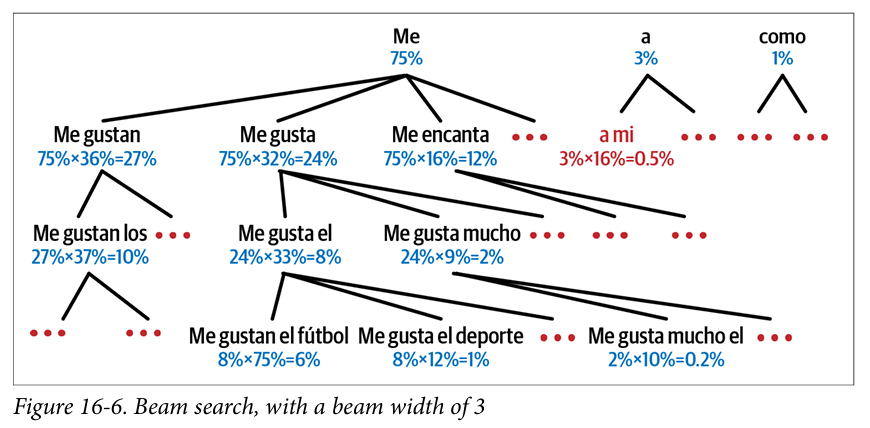

In [ ]:
# extra code – a basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # list of best (log_proba, translation)
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]

    # extra code – displays the top first words in verbose mode
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [ ]:
# extra code – shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

1/1 [==============================] - 0s 21ms/step


'me encanta la carne y los demás'

In [ ]:
# extra code – shows how beam search can help
beam_search(sentence_en, beam_width=3, verbose=True)

1/1 [==============================] - 0s 20ms/step
Top first words: [(np.float32(-0.26662076), np.str_('me')), (np.float32(-2.2443924), '[UNK]'), (np.float32(-2.4201071), np.str_('yo'))]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(np.float32(-1.3252444), 'me encanta'), (np.float32(-1.4799056), 'me [UNK]'), (np.float32(-1.6558384), 'me gustan')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(np.float32(-1.8018364), 'me gustan los'), (np.float32(-1.8530132), 'me [UNK] los'), (np.float32(-2.299043), 'me encanta la')]
1/1 [==============================] - 0s 31ms/step
Top translations so far: [(np.float32(-2.4606094), 'me gustan los perros'), (np.float32(-2.4619718), 'me [UNK] los perros'), (np.float32(-2.563631), 'me gustan los gatos')]
1/1 [==============================] - 0s 21ms/step
Top translations so far: [(np.float32(-2.5169344), 'me [UNK] los perros y'), (np.float32(-2.5478232), 'me gustan los perros y'), (np.fl

'me gustan los gatos y perros'

## Attention

Attentionとは、**翻訳や文生成の精度を飛躍的に高めた技術**です。

従来のエンコーダ・デコーダモデルでは、**入力文全体を1つのベクトル（文脈ベクトル）に圧縮**して、それを元に翻訳していました。
しかし、この方法では長い文になると情報が欠落しやすく、精度が下がってしまいます。

Attentionの基本アイデアは、「毎回、**出力を生成する際に、入力文のどの単語に注目するかを決める**」

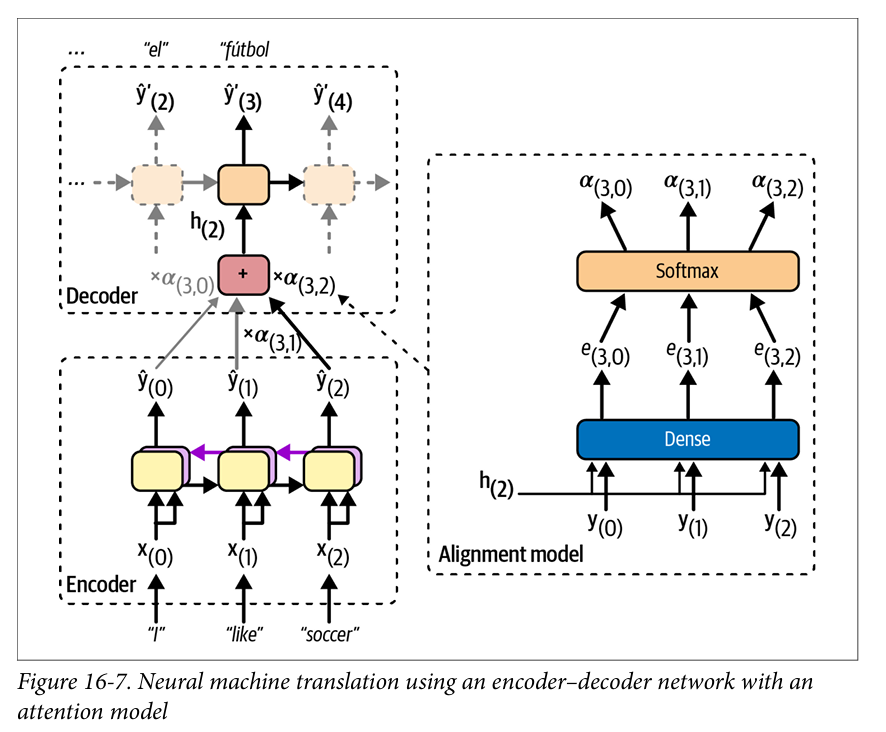

この図では、「I like soccer」という文を「Me gusta el fútbol」に翻訳するモデルを例にしています。

1. **Decoder側の現在の状態 $h(2)$** を使って、
   Encoderの各出力 $y(0), y(1), y(2)$（= “I”, “like”, “soccer”）と比較する

2. **類似度 $e(3,0), e(3,1), e(3,2)$** を計算（Dense層で）

3. Softmax関数で重み（Attentionスコア） $\alpha(3,0), \alpha(3,1), \alpha(3,2)$ に変換
   → 「どの単語にどれだけ注目するか」を決定

4. 重み付き平均を取って、**文脈ベクトル（context vector）** を生成
   → この文脈ベクトルが、Decoderの出力に使われる

つまり、“fútbol”を生成する際に：

* “soccer” に強く注意（αが大きくなる）
* “I” や “like” にはあまり注目しない（αが小さい）

こうやって、モデルが「今、何を見ているか」が分かるようになる！

### Attentionの効果

* 長文でも情報を取りこぼさない
* 単語の「対応関係（アライメント）」を可視化できる
* 翻訳だけでなく、要約・画像キャプション生成などにも応用される

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [ ]:
# extra code – this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 113s 31ms/step - loss: 2.2451 - accuracy: 0.5398 - val_loss: 1.5156 - val_accuracy: 0.6511
Epoch 2/10
3125/3125 [==============================] - 76s 24ms/step - loss: 1.3622 - accuracy: 0.6785 - val_loss: 1.3297 - val_accuracy: 0.6860
Epoch 3/10
3125/3125 [==============================] - 75s 24ms/step - loss: 1.1849 - accuracy: 0.7117 - val_loss: 1.2549 - val_accuracy: 0.7027
Epoch 4/10
3125/3125 [==============================] - 76s 24ms/step - loss: 1.0674 - accuracy: 0.7340 - val_loss: 1.2294 - val_accuracy: 0.7084
Epoch 5/10
3125/3125 [==============================] - 75s 24ms/step - loss: 0.9735 - accuracy: 0.7528 - val_loss: 1.2236 - val_accuracy: 0.7100
Epoch 6/10
3125/3125 [==============================] - 76s 24ms/step - loss: 0.8956 - accuracy: 0.7687 - val_loss: 1.2373 - val_accuracy: 0.7104
Epoch 7/10
3125/3125 [==============================] - 75s 24ms/step - loss: 0.8280 - accuracy: 0.7834 - val_loss: 1.2545 

In [ ]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 34ms/step


'me gusta el fútbol y también vaya a la playa'

In [ ]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

1/1 [==============================] - 0s 30ms/step
Top first words: [(np.float32(-0.01393457), np.str_('me')), (np.float32(-4.963224), np.str_('endofseq')), (np.float32(-5.425981), np.str_('prefiero'))]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(np.float32(-0.03919526), 'me gusta'), (np.float32(-3.9213688), 'me el'), (np.float32(-4.963224), np.str_('endofseq'))]
1/1 [==============================] - 0s 23ms/step
Top translations so far: [(np.float32(-0.32762212), 'me gusta el'), (np.float32(-2.7018526), 'me gusta la'), (np.float32(-3.0076897), 'me gusta fútbol')]
1/1 [==============================] - 0s 34ms/step
Top translations so far: [(np.float32(-0.34198052), 'me gusta el fútbol'), (np.float32(-2.7350512), 'me gusta la playa'), (np.float32(-3.011242), 'me gusta fútbol y')]
1/1 [==============================] - 0s 22ms/step
Top translations so far: [(np.float32(-0.34560376), 'me gusta el fútbol y'), (np.float32(-2.747893), 'me gusta la playa 

'me gusta el fútbol y también vaya a la playa'

## Attention Is All You Need: The Transformer Architecture

### Transformer アーキテクチャとは？

Transformerは、**RNNを使わずに文脈を処理する新しいモデル構造**として2017年に登場しました。
従来の順序処理（RNN）とは異なり、**Attention機構をベースに並列処理が可能**というのが最大の特徴です。

この図は、元論文のTransformer構造（Encoder–Decoder型）を示したものです。

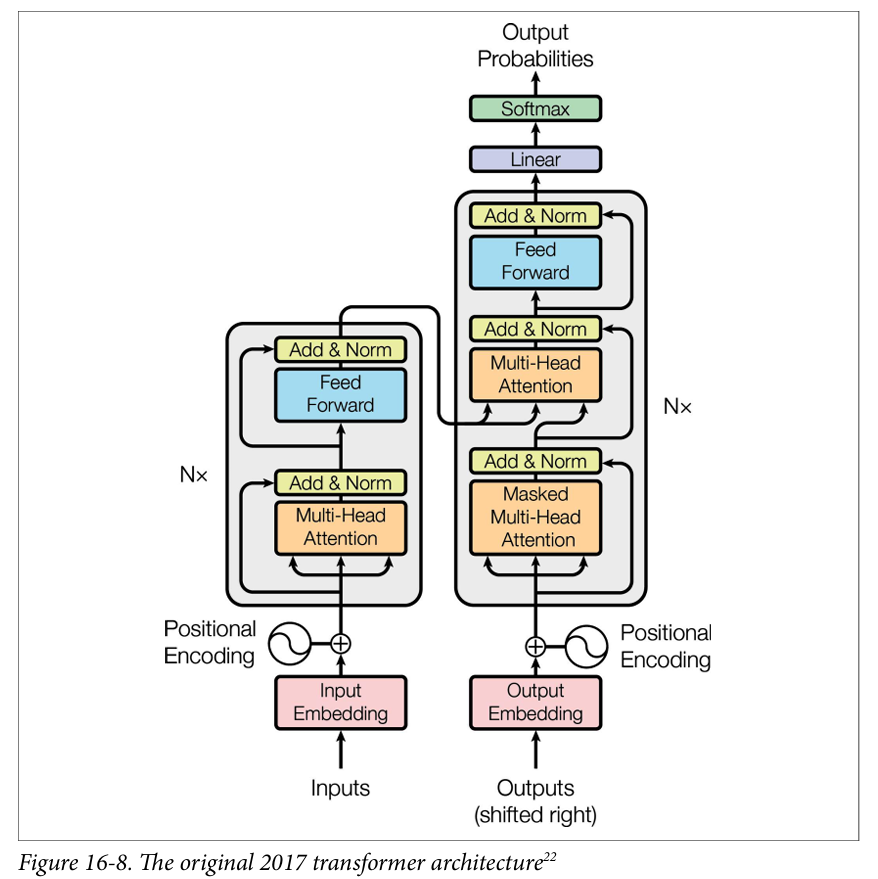

### 左側：Encoder（エンコーダ）

入力文を処理して、意味ベクトルに変換します。構造は以下の繰り返し（×N）：

#### 各ブロックの構成

1. **Input Embedding**：単語をベクトル化（語彙ID → 連続ベクトル）
2. **Positional Encoding**：順序情報を追加（Self-Attentionには順番がないため）
3. **Multi-Head Attention**（自己注意）
   → 文中の他の単語に「どれだけ注目すべきか」を学習
4. **Add & Norm**：残差接続 + 正規化
5. **Feed Forward**：全結合ネットワークによる変換
6. **再度 Add & Norm**

これを何層か重ねて、**文全体の意味表現**を作ります。

### 右側：Decoder（デコーダ）

翻訳文や出力文を生成します。エンコーダと似ていますが、2点の違いがあります：

1. **Masked Multi-Head Attention**：
   → 未来の単語を見ないようにマスク（次の単語を生成するときに前だけを見る）

2. **Multi-Head Attention (エンコーダの出力に対する注意)**
   → 入力文全体を参照して、今の単語に関連する情報を取り出す

3. **Feed Forward + Add & Norm**：通常通り処理

4. 最後に **Linear + Softmax** によって、語彙リストから次の単語を予測します。


### Transformerの強み

* RNNと違い、**並列処理が可能**（GPUで高速）
* 長文でも**依存関係を効率よく扱える**（Self-Attention）
* 現在のNLPの中心的モデル（BERT, GPT, T5など）はすべてTransformer系


### 補足：Multi-Head Attentionとは？

「1つのAttentionだけでは見落としがあるかも」という前提のもと：

* **異なる角度から複数の注意を並列に計算**
* それらを**結合（Concat）して1つの情報に統合**

→ 「複数の意味的な関連性」を同時に学習できます。


Positional Encoding

In [ ]:
max_length = 50  # max length in the whole training set
embed_size = 128
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [ ]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

Multi-head attention

In [ ]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

In [ ]:
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

Output and training

In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 182s 50ms/step - loss: 1.8750 - accuracy: 0.5938 - val_loss: 1.4172 - val_accuracy: 0.6629
Epoch 2/10
3125/3125 [==============================] - 149s 48ms/step - loss: 1.3696 - accuracy: 0.6693 - val_loss: 1.3123 - val_accuracy: 0.6825
Epoch 3/10
3125/3125 [==============================] - 156s 50ms/step - loss: 1.2646 - accuracy: 0.6892 - val_loss: 1.2188 - val_accuracy: 0.7034
Epoch 4/10
3125/3125 [==============================] - 151s 48ms/step - loss: 1.2008 - accuracy: 0.7009 - val_loss: 1.1759 - val_accuracy: 0.7118
Epoch 5/10
3125/3125 [==============================] - 147s 47ms/step - loss: 1.1537 - accuracy: 0.7091 - val_loss: 1.1648 - val_accuracy: 0.7095
Epoch 6/10
3125/3125 [==============================] - 167s 53ms/step - loss: 1.1149 - accuracy: 0.7164 - val_loss: 1.1262 - val_accuracy: 0.7193
Epoch 7/10
3125/3125 [==============================] - 174s 56ms/step - loss: 1.0844 - accuracy: 0.7223 - val_loss: 1

In [ ]:
translate("I like soccer and also going to the beach")

1/1 [==============================] - 0s 38ms/step


'me gusta el fútbol y también ir a la playa'

## Hugging Face

Hugging Faceの`transformers`ライブラリは、
**事前学習済みの最新NLPモデル（BERT, GPT, T5など）を簡単に使えるようにしたPythonライブラリ**です。

* たった数行のコードで**翻訳・要約・文章分類・質問応答・文章生成**などが可能
* モデルのダウンロードとトークナイズ（前処理）も自動でやってくれる
* 研究者・エンジニアの**業界標準ツール**


### インストール方法

```bash
pip install transformers
pip install torch  # PyTorchバックエンドを使う場合
```

### 例①：翻訳モデル（英語 → 日本語）

```python
from transformers import pipeline

translator = pipeline("translation_en_to_ja", model="staka/fugumt-en-ja")
result = translator("I am a student.")
print(result[0]['translation_text'])
```

* `"pipeline"` は用途に応じて最適な前処理＋モデルを自動で設定してくれる
* モデル名はHugging Face Hub（[https://huggingface.co/models）で検索可能](https://huggingface.co/models）で検索可能)


### 例②：文章生成（GPT系）

```python
from transformers import pipeline

generator = pipeline("text-generation", model="gpt2")
result = generator("Once upon a time", max_length=50, num_return_sequences=1)
print(result[0]['generated_text'])
```

### 例③：感情分析

```python
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
result = classifier("I love studying NLP!")
print(result)
```

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")  # many other tasks are available
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

モデルを指定する場合

In [ ]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


[{'label': 'contradiction', 'score': 0.9790192246437073}]

トークナイザーやモデル、設定、callback のモジュールも導入できる

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

Tuple を入力するのもOK

In [ ]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123817 ,  1.17868   ,  1.4100995 ],
       [-0.01478346,  1.0962477 , -0.99199575]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.43523633, 0.54856664],
       [0.2265597 , 0.6881726 , 0.08526774]], dtype=float32)>

In [ ]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

Fine-tuning もできる

In [ ]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 45s 45s/step - loss: 0.6666 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 91ms/step - loss: nan - accuracy: 0.5000


自分でアプリを作りましょう

Sample:
https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("fill-in-base-model")
pipe.load_lora_weights("JujoHotaru/lora")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]

Couldn't connect to the Hub: 401 Client Error. (Request ID: Root=1-683d0ddb-0956e381370709ff552369ac;39f801f6-b9e4-44d2-b0bd-b2385b972b80)

Repository Not Found for url: https://huggingface.co/api/models/fill-in-base-model.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password..
Will try to load from local cache.


OSError: Cannot load model fill-in-base-model: model is not cached locally and an error occurred while trying to fetch metadata from the Hub. Please check out the root cause in the stacktrace above.